In [18]:
import os
from random import shuffle

import numpy as np
import imageio

import matplotlib.pyplot as plt

from skimage.color import rgb2gray
from skimage import filters
from skimage.segmentation import clear_border
from skimage.morphology import closing, square
from skimage.metrics import mean_squared_error

from skimage.morphology import disk
from skimage.segmentation import watershed
from skimage.filters import rank

In [20]:
def get_images(tiles_dir, amount, rand=False):
    """Get a list of pairs of images and masks read from within a specific folder

    Args:
         tiles_dir: Path to directory containing all tiles folders
         amount: Total amount of images to read from the dataset folders
         rand: Whether to shuffle or not pairs after reading them
    """
    images = []
    tiles = os.listdir(tiles_dir)

    # Iterate over all tiles of images
    for tile in tiles:
        if amount < 0:
                break

        current_tile = tiles_dir + f"/{tile}/"
        images_path = current_tile + "images/"
        mask_path = current_tile + "masks/"

        # From within a specific tile, read both image and mask and save dict to list
        for image_uri in os.listdir(images_path):
            img = imageio.imread(images_path + image_uri)
            mask = imageio.imread(mask_path + image_uri)

            images.append({"img": img, "label": mask})

            amount -= 1

    if rand:
        shuffle(images)
    return images

In [21]:
def apply_threshold(image):
    """Apply Otsu thresholding filter to given image, returning the generated binary mask"""
    grayscale = rgb2gray(image)
    thresh = filters.threshold_otsu(grayscale)
    binary = closing(grayscale > thresh, square(3))
    binary = clear_border(binary)

    return binary

In [22]:
def region_segmentation(image):
    """Apply Watershed region segmentation algorithm, returning the generated gradient for each pixel"""
    gray = rgb2gray(image)
    # markers = rank.gradient(gray , disk(5)) < 10
    # markers = ndi.label(markers)[0]

    gradient = rank.gradient(gray, disk(5))

    gradient_filtered = np.copy(gradient)
    gradient_filtered[gradient > 128] = 255
    gradient_filtered[gradient <= 128] = 0

    return gradient_filtered

In [23]:
def visualise_semantic(images):
    """Save dict of images (original image, otsu prediction, watershed prediction and true label) to the predictions folder"""
    for idx, semantic in enumerate(images):

        plt.subplot(141)
        plt.title("Original")
        plt.imshow(semantic["img"])

        plt.subplot(142)
        plt.title("Region")
        plt.imshow(semantic["segmentation"][0], cmap=plt.cm.gray)

        plt.subplot(143)
        plt.title("Final")
        plt.imshow(semantic["segmentation"][1], cmap=plt.cm.gray)

        plt.subplot(144)
        plt.title("Label")
        plt.imshow(semantic["label"], cmap=plt.cm.gray)
        plt.savefig(f"predictions/filters/img_{idx}.png")

        print("Error: ", mean_squared_error(semantic["img"], semantic["label"]))

In [24]:
def segment_images(images):
    """Segment a list of images using the Otsu and Watershed algorithms, returning dictionaries containing original input and segmented masks"""
    semantic_segmentation = []
    for image in images:
        otsu = apply_threshold(image['img'])
        region = region_segmentation(image['img'])

        # Use the Otsu threshold as the final mask, as it outperformed the Watershed Gradient values
        final = np.ones((image['img'].shape[0], image['img'].shape[1]))
        final[region != 255] = 0
        semantic_segmentation.append({"img": image['img'], "segmentation": [otsu, region, final], "label": image['label']})
    return semantic_segmentation

/tmp/ipykernel_17150/1396509551.py:11: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(images_path + image_uri)
/tmp/ipykernel_17150/1396509551.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask = imageio.imread(mask_path + image_uri)
/tmp/ipykernel_17150/1462828468.py:5: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  region = region_segmentation(image['img'])


Error:  30454.56835428874
Error:  21397.218485514324
Error:  32619.386789957684
Error:  19608.85727437337
Error:  23790.02623494466
Error:  39451.26674397787
Error:  18817.373504638672
Error:  43037.14805603027
Error:  39261.79825846354
Error:  25878.72137959798
Error:  38659.26191711426
Error:  30158.956415812176
Error:  44475.296971639
Error:  23752.703872680664
Error:  17787.15918477376
Error:  31283.289240519207
Error:  21594.594039916992
Error:  13404.027221679688
Error:  6015.613296508789
Error:  24131.075083414715
Error:  9533.158767700195
Error:  14273.200780232748
Error:  8407.539677937826
Error:  5628.781341552734
Error:  6238.806376139323
Error:  8352.023264567057
Error:  8976.622904459635
Error:  20799.260452270508
Error:  10713.875244140625
Error:  19321.761540730793
Error:  24618.708913167316
Error:  7534.708312988281
Error:  25719.047083536785
Error:  14164.97533162435
Error:  15346.82772318522
Error:  24286.170288085938
Error:  19339.27453104655
Error:  2878.33032226562

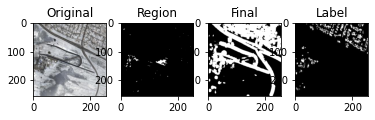

In [28]:
def main():
    """Read images from dataset directory, segment using Otsu and Watershed and then save to predictions folder"""
    images = get_images("data/processed", 70, True)
    semantic_segmentation = segment_images(images)
    visualise_semantic(semantic_segmentation)

if __name__ == "__main__":
    main()